In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
import warnings
warnings.filterwarnings("ignore")

# DOI 10.24432/C5HP4Z

In [137]:
nomes_colunas = ['ID',  'Diagnosis', 'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3']

In [138]:
df = pd.read_csv('wdbc.data')
df_original = df
df.columns = nomes_colunas

In [139]:
df.head()

,ID,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  568 non-null    int64  
 1   Diagnosis           568 non-null    object 
 2   radius1             568 non-null    float64
 3   texture1            568 non-null    float64
 4   perimeter1          568 non-null    float64
 5   area1               568 non-null    float64
 6   smoothness1         568 non-null    float64
 7   compactness1        568 non-null    float64
 8   concavity1          568 non-null    float64
 9   concave_points1     568 non-null    float64
 10  symmetry1           568 non-null    float64
 11  fractal_dimension1  568 non-null    float64
 12  radius2             568 non-null    float64
 13  texture2            568 non-null    float64
 14  perimeter2          568 non-null    float64
 15  area2               568 non-null    float64
 16  smoothne

In [141]:
df['Diagnosis'].value_counts()

Diagnosis
B    357
M    211
Name: count, dtype: int64

In [142]:
df.drop(columns=['ID'], inplace=True)
#df.drop(columns=['Diagnosis'], inplace=True)
#df['Diagnosis'] = df['Diagnosis'].replace({'M': 4, 'B': 2})

le = LabelEncoder()
df['Diagnosis'] = le.fit_transform(df['Diagnosis'])

df.replace('?', np.nan, inplace=True)
df = df.astype('float64')
df.dropna(inplace=True)

In [143]:
def plot_elbow_and_get_best_k(data, max_k):
    wss = []  # Lista para armazenar os valores de WSS para cada k

    # Calcula o WSS para cada número de clusters
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)

    # Calcula as diferenças relativas entre os valores de WSS
    deltas = np.diff(wss)  # Diferença entre WSS consecutivos
    ratios = -np.diff(deltas)  # Segunda diferença (declínio do declive)

    # Encontra o índice com maior declínio relativo
    best_k = np.argmax(ratios) + 2  # +2 porque índice se refere ao (k-2) em ratios

    # Plota o gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), wss, marker='o', linestyle='-', color='b', label='WSS')
    plt.title('Método Elbow', fontsize=16)
    plt.xlabel('Número de Clusters (k)', fontsize=14)
    plt.ylabel('WSS (Within-Cluster Sum of Squares)', fontsize=14)
    plt.xticks(range(1, max_k + 1))
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()


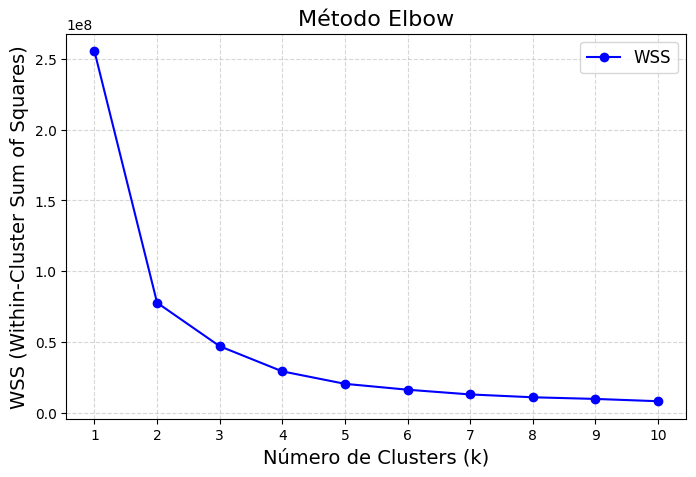

In [144]:
plot_elbow_and_get_best_k(df, max_k=10)

In [145]:
k = 4 

In [146]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [147]:
melhor_k = 0
melhor_razao = 0
melhor_wss = 0
melhor_bss = 0
seed_salva = 0

#for k in range(2, 10):
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df)

wss = kmeans.inertia_
total_ss = np.sum((df - np.mean(df, axis=0))**2).sum()
bss = total_ss - wss
razao = bss/total_ss


melhor_razao = razao
melhor_k = k
melhor_wss = wss
melhor_bss = bss
melhor_seed = seed

print(f"razao: {razao:0.5f} | k: {k} | seed: {seed}", end='\r')

print(f"WSS (Within-Cluster Sum of Squares): {melhor_wss}")
print(f"BSS (Between-Cluster Sum of Squares): {melhor_bss}")
print(f"Melhor razao BSS/(WSS + BSS): {melhor_razao} | melhor k: {melhor_k} | seed {melhor_seed}")

WSS (Within-Cluster Sum of Squares): 181.02315382043705
BSS (Between-Cluster Sum of Squares): 303.43810216267764
Melhor razao BSS/(WSS + BSS): 0.6263413191771389 | melhor k: 4 | seed 34958


In [148]:
def information_gain(X, y):
    info_gains = {}
    
    # Entropia do alvo (Diagnosis)
    entropy_y = -np.sum(np.log2(y.value_counts(normalize=True)) * y.value_counts(normalize=True))
    
    # Calcular Information Gain para cada feature
    for feature in X.columns:
        # Calcular a entropia condicional (com base na feature)
        feature_values = X[feature]
        
        # Média ponderada das entropias das partes (conjuntos distintos)
        feature_entropy = 0
        for value in feature_values.unique():
            # Dividir os dados em subconjuntos para cada valor único da feature
            subset_y = y[feature_values == value]
            subset_entropy = -np.sum(np.log2(subset_y.value_counts(normalize=True)) * subset_y.value_counts(normalize=True))
            weight = len(subset_y) / len(y)
            feature_entropy += weight * subset_entropy
        
        # Calcular o Information Gain para a feature
        info_gain = entropy_y - feature_entropy
        info_gains[feature] = info_gain
    
    return info_gains

In [149]:
kmeans = KMeans(n_clusters=k, random_state=melhor_seed)
kmeans.fit(df)

df = pd.DataFrame(df, columns=df_original.columns)
df['cluster'] = kmeans.fit_predict(df)

X = df.drop(columns=['cluster'])
y = df['Diagnosis']

#info_gains = information_gain(X, y)
#info_gains = pd.Series(info_gains).sort_values(ascending=False)

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

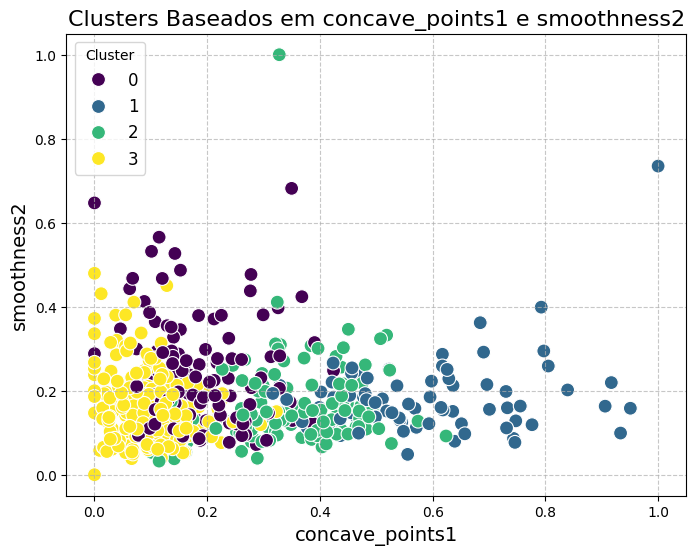

In [151]:
col1 = 'concave_points1'
col2 = 'smoothness2'

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x=col1,
    y=col2,
    hue='cluster',  # Colore os pontos pelos clusters
    palette='viridis',
    #style='cluster',
    s=100  # Tamanho dos pontos
)
plt.title(f'Clusters Baseados em {col1} e {col2}', fontsize=16)
plt.xlabel(col1, fontsize=14)
plt.ylabel(col2, fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()